In [2]:
import pandas_datareader.data as web
import datetime as dt 
import pandas as pd 
import matplotlib.pyplot as plt 
from arch import arch_model 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
import numpy as np
import itertools 
from sklearn.metrics import mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

# 1) Load the Data

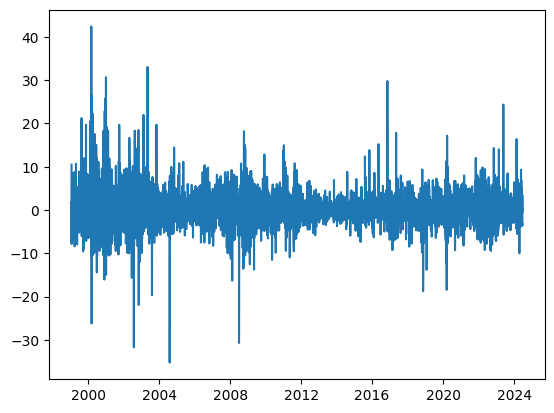

In [2]:
df = pd.read_csv('NVDA.csv')
df = df[['Date','Close']] # take relevant data
df['Date']
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year,month=month,day=day)

datetime_obj = str_to_datetime('1999-01-22')

df['Date'] = df['Date'].apply(str_to_datetime) # Turn dates into datetime objects (not strings)
df.index = df.pop('Date')
returns = 100*df['Close'].pct_change().dropna()
plt.plot(returns) # good candidate for GARCH because volatility changes over time

# 2) Fit a GARCH Model

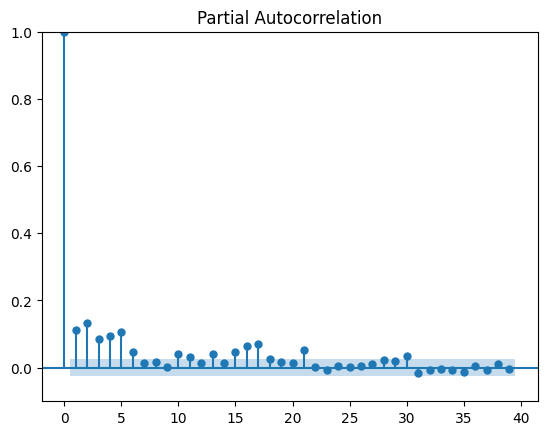

In [3]:
fig, ax = plt.subplots()
plot_pacf(returns**2,ax=ax)
ax.set_ylim(-0.1,1)
plt.show()

In [4]:
model = arch_model(returns,p=1,q=1)
model_fit = model.fit()
model_fit.summary

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46632.13791804343
Iteration:      2,   Func. Count:     16,   Neg. LLF: 64828641687.79334
Iteration:      3,   Func. Count:     24,   Neg. LLF: 59058698.70378072
Iteration:      4,   Func. Count:     30,   Neg. LLF: 16836.529474980336
Iteration:      5,   Func. Count:     36,   Neg. LLF: 16709.396943628555
Iteration:      6,   Func. Count:     41,   Neg. LLF: 34366.30611894364
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17756.836524704602
Iteration:      8,   Func. Count:     56,   Neg. LLF: 23164.068091502253
Iteration:      9,   Func. Count:     62,   Neg. LLF: 16704.06314815948
Iteration:     10,   Func. Count:     67,   Neg. LLF: 16703.67579966765
Iteration:     11,   Func. Count:     72,   Neg. LLF: 16703.635284082105
Iteration:     12,   Func. Count:     77,   Neg. LLF: 16703.63405367086
Iteration:     13,   Func. Count:     82,   Neg. LLF: 16703.633989142523
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1670

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16703.6
Distribution:                  Normal   AIC:                           33415.3
Method:            Maximum Likelihood   BIC:                           33442.3
                                        No. Observations:                 6394
Date:                Mon, Jun 24 2024   Df Residuals:                     6393
Time:                        15:35:07   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2335  5.268e

In [5]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

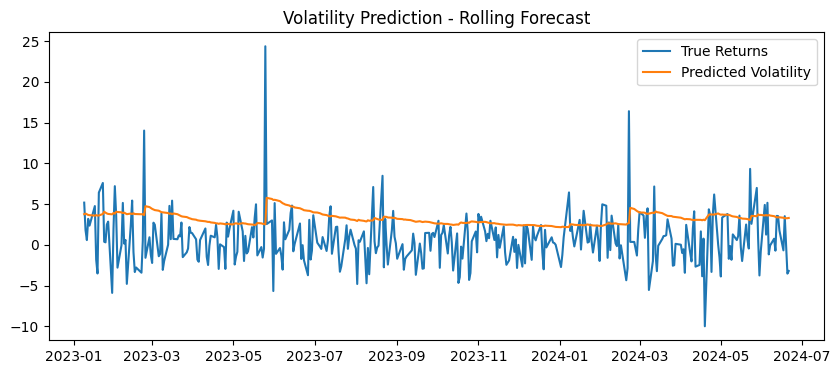

In [6]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Returns','Predicted Volatility'])

In [7]:
### Using the Model ###

train = returns 
model = arch_model(train, p=1,q=1)
model_fit = model.fit(disp='off')

pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + dt.timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

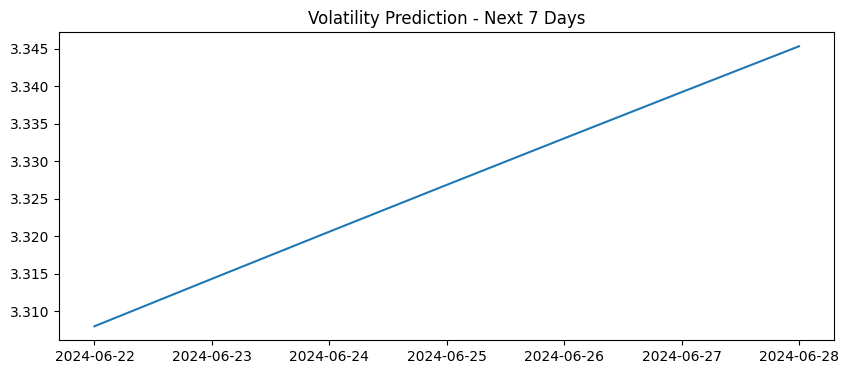

In [8]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days')

# 3) Fit an ARIMA Model 

In [9]:
price = df['Close']
price.describe()

count    6395.000000
mean        5.735178
std        14.335830
min         0.034115
25%         0.275750
50%         0.455750
75%         4.123375
max       135.580002
Name: Close, dtype: float64

## Determine d param
Number of differencing required to achieve stationarity: 1

In [10]:
# ADF Test for stationarity 
result = adfuller(price.dropna())
print(f"ADF Stat: {result[0]}")
print(f"P-Value: {result[1]}") # clearly, NVDA is not stationary

ADF Stat: 8.618906693214436
P-Value: 1.0


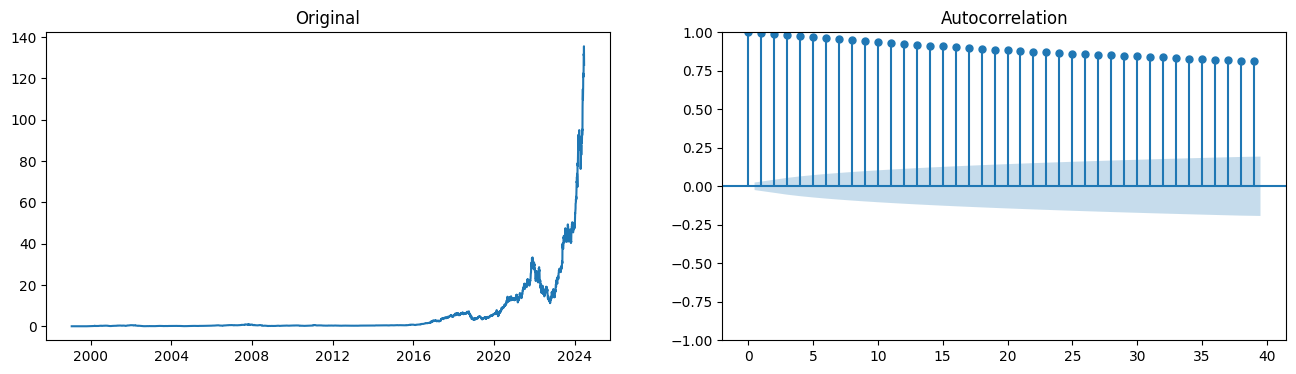

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(price)
ax1.set_title("Original")
plot_acf(price, ax=ax2);

(-0.25, 1.0)

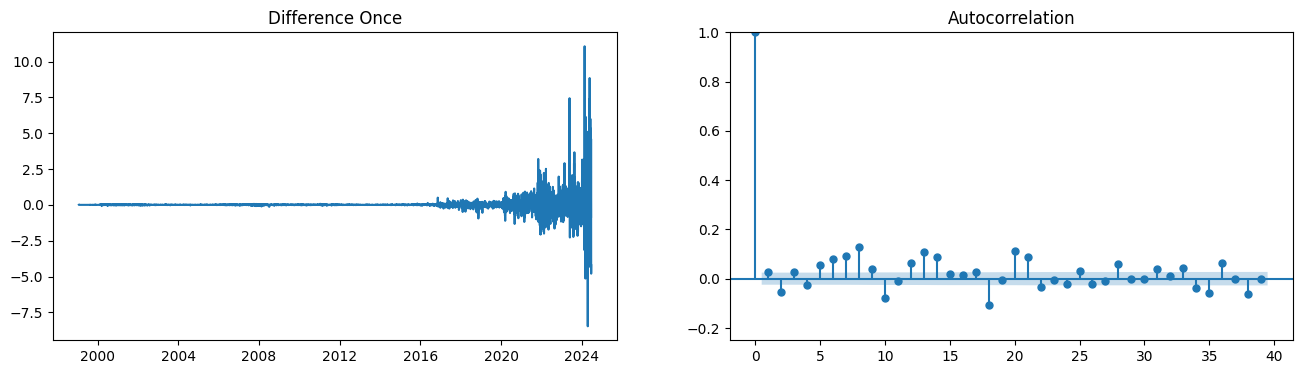

In [12]:
diff = price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax=ax2);
ax2.set_ylim(-0.25,1)

## Determine p param
Q: first autocorrelation lag that is outside of the acf range: 3

P: first autocorrelation lag that is outside of the pacf range: 3 

(-0.25, 1.0)

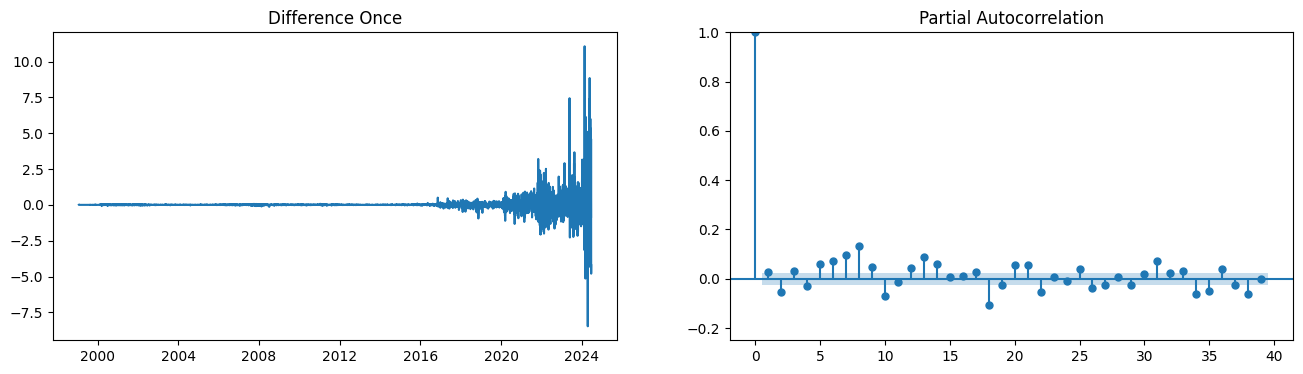

In [94]:
diff = price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_pacf(diff, ax=ax2);
ax2.set_ylim(-0.25,1)

In [14]:
mdl_arima = ARIMA(price, order=(3,1,3))
mdl_arima_fit = mdl_arima.fit()
mdl_arima_fit.summary()

C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 6395
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4355.831
Date:                Mon, 24 Jun 2024   AIC                           8725.661
Time:                        15:35:47   BIC                           8773.003
Sample:                             0   HQIC                          8742.049
                               - 6395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6936      0.013     52.095      0.000       0.668       0.720
ar.L2          0.9761      0.005    207.730      0.000       0.967       0.985
ar.L3         -0.7139      0.014    -52.724      0.000      -0.740      -0.687
ma.L1         -0.7416      0.013    -57.768      0.000      -0.767      -0.716
ma.L2         -0.9621      0.006   -153.991      0.000      -0.974      -0.950
ma.L3          0.7790      0.013     60.783      0.000       0.754       0.804
sigma2         0.2286      0.001    354.548      0.000       0.227       0.230
===================================================================================
Ljung-Box (L1) (Q):                  14.21   Jarque-Bera (JB):           3316402.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            5291.01   Skew:                             3.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       114.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(array([8.31741240e-05, 3.32696496e-04, 4.15870620e-04, 1.15612032e-02,
        5.11687211e-01, 5.90536280e-03, 1.33078598e-03, 2.49522372e-04,
        2.49522372e-04, 8.31741240e-05]),
 array([-8.29868163, -6.41862376, -4.5385659 , -2.65850804, -0.77845017,
         1.10160769,  2.98166555,  4.86172342,  6.74178128,  8.62183914,
        10.50189701]),
 <BarContainer object of 10 artists>)

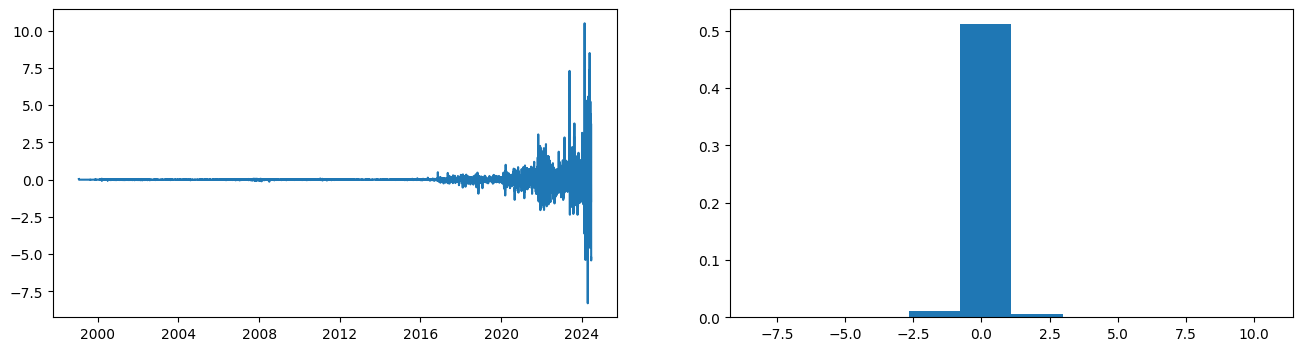

In [15]:
residuals = pd.DataFrame(mdl_arima_fit.resid)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(residuals)
ax2.hist(residuals, density=True)

C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


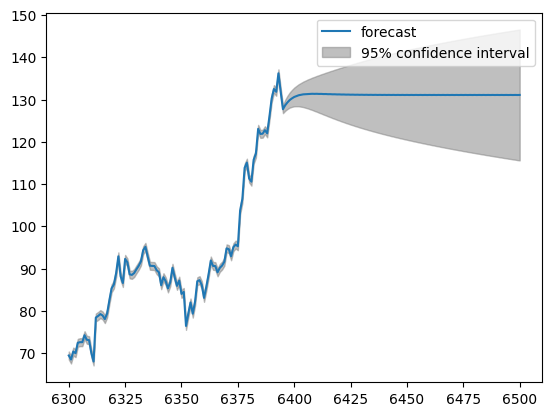

In [16]:
plot_predict(mdl_arima_fit,
    start = 6300, 
    end = 6500,
    dynamic = False
);

# 1) Load Data

In [3]:
df = pd.read_csv('NVDA.csv')
df = df[['Date','Close']] # take relevant data
df['Date']
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year,month=month,day=day)

datetime_obj = str_to_datetime('1999-01-22')

df['Date'] = df['Date'].apply(str_to_datetime)
df.set_index('Date',inplace=True)

train_size = int(len(df)*0.8)
val_size = int(len(df)*0.1)
test_size = len(df) - train_size - val_size

train, val, test = df[:train_size], df[train_size: train_size+val_size], df[train_size+val_size:]

In [15]:
def check_stationarity(series): 
    result = adfuller(series) 
    return result[1] < 0.05 # indicates stationarity 

def difference_if_needed(series):
    if not check_stationarity(series['Close']):
        series_diff = series['Close'].diff().dropna() 
    else: 
        series_diff = series['Close']
    return series_diff 

train_diff = difference_if_needed(train)
val_diff = difference_if_needed(val)


0.004297000000000002

# 2) Fit ARIMA

In [18]:
# ARIMA Grid Search 
p = d = q = range(0,5)
pdq = list(itertools.product(p,d,q))

print("pdq list complete, beginning grid search")

best_aic = np.inf 
best_order = None 
best_mse = np.inf 
for param in pdq: 
    try: 

        model_arima = ARIMA(train_diff, order=param)
        model_arima_fit = model_arima.fit() 

        predictions = model_arima_fit.forecast(steps=len(val))
        mse = mean_squared_error(val_diff, predictions[:len(val_diff)])  
        if mse < best_mse: 
            best_mse = mse 
            best_order = param 
        print(f'Tried order: {param} with MSE: {best_mse}')
    except Exception as e: 
        print(f"Error with order {param}: {e}")                                        

print(f"Best ARIMA order: {best_order} with MSE: {best_mse}")

pdq list complete, beginning grid search
Tried order: (0, 0, 0) with MSE: 0.1507006387303876
Tried order: (0, 0, 1) with MSE: 0.1507006387303876
Tried order: (0, 0, 2) with MSE: 0.1507006387303876
Tried order: (0, 0, 3) with MSE: 0.15069980606395078
Tried order: (0, 0, 4) with MSE: 0.1506994233514186
Tried order: (0, 1, 0) with MSE: 0.1506994233514186
Tried order: (0, 1, 1) with MSE: 0.15067758417246913
Tried order: (0, 1, 2) with MSE: 0.15067758417246913
Tried order: (0, 1, 3) with MSE: 0.15066881331483098
Tried order: (0, 1, 4) with MSE: 0.15066881331483098
Tried order: (0, 2, 0) with MSE: 0.15066881331483098
Tried order: (0, 2, 1) with MSE: 0.15066881331483098
Tried order: (0, 2, 2) with MSE: 0.15066881331483098
Tried order: (0, 2, 3) with MSE: 0.15066881331483098
Tried order: (0, 2, 4) with MSE: 0.15066881331483098
Tried order: (0, 3, 0) with MSE: 0.15066881331483098
Tried order: (0, 3, 1) with MSE: 0.15066881331483098
Tried order: (0, 3, 2) with MSE: 0.15066881331483098
Tried orde

In [61]:
model_arima = ARIMA(train['Close'], order=(5,1,0))
model_arima_fit = model_arima.fit()

arima_pred = model_arima_fit.forecast(steps=1)
residuals = model_arima_fit.resid

In [62]:
model_arima_fit.summary()
residuals

Date
1999-01-22    0.041016
1999-01-25    0.004297
1999-01-26   -0.003359
1999-01-27   -0.000311
1999-01-28   -0.000332
                ...   
2019-05-16    0.022062
2019-05-17   -0.091227
2019-05-20   -0.136951
2019-05-21    0.085818
2019-05-22   -0.064880
Length: 5116, dtype: float64

# 3) Fit GARCH

In [66]:
# fit GARCH model 
model_garch = arch_model(residuals, vol='Garch', p=1, q=1)
model_garch_fit = model_garch.fit(disp='off')

# GARCH predictions 
garch_pred = model_garch_fit.forecast(horizon=1)
garch_pred_var = garch_pred.variance.iloc[-1,0]

garch_pred_var

0.0089363596125361

# 4) Combine ARIMA and GARCH models

In [77]:
arima_garch_upper = arima_pred + np.sqrt(garch_pred_var)
arima_garch_lower = arima_pred - np.sqrt(garch_pred_var)

print("ARIMA Prediction (Next Day):", arima_pred)
print("GARCH Prediction (Next Day Variance):", garch_pred_var)
print("ARIMA-GARCH Prediction (Next Day Price Interval):", arima_garch_lower.iloc[0], "to", arima_garch_upper.iloc[0])

ARIMA Prediction (Next Day): 5116    3.798982
dtype: float64
GARCH Prediction (Next Day Variance): 0.0089363596125361
ARIMA-GARCH Prediction (Next Day Price Interval): 3.704449795263325 to 3.8935144361937333


In [86]:
arima_garch_lower.iloc[0]
arima_garch_upper.iloc[0]

3.8935144361937333

# 5) Extend to recursive forecast

In [96]:
predictions = []
lower_bounds = []
upper_bounds = []

history = train['Close'].copy() 
for t in range(len(test)): 
    model_arima = ARIMA(history, order=(3,1,3))
    model_arima_fit = model_arima.fit() 

    arima_pred = model_arima_fit.forecast(steps=1).iloc[0] 

    residuals = model_arima_fit.resid

    model_garch = arch_model(residuals, vol='Garch', p=1, q=1)
    model_garch_fit = model_garch.fit(disp='off')

    garch_pred = model_garch_fit.forecast(horizon=1)
    garch_pred_var = garch_pred.variance.iloc[-1,0]
    garch_pred_std = np.sqrt(garch_pred_var)

    next_day_pred_upper = arima_pred + garch_pred_std 
    next_day_pred_lower = arima_pred - garch_pred_std 

    predictions.append(arima_pred)
    lower_bounds.append(next_day_pred_upper)
    upper_bounds.append(next_day_pred_lower)
    history = pd.concat([history, pd.Series(test['Close'].iloc[t], index=[test.index[t]])])
    

KeyboardInterrupt: 

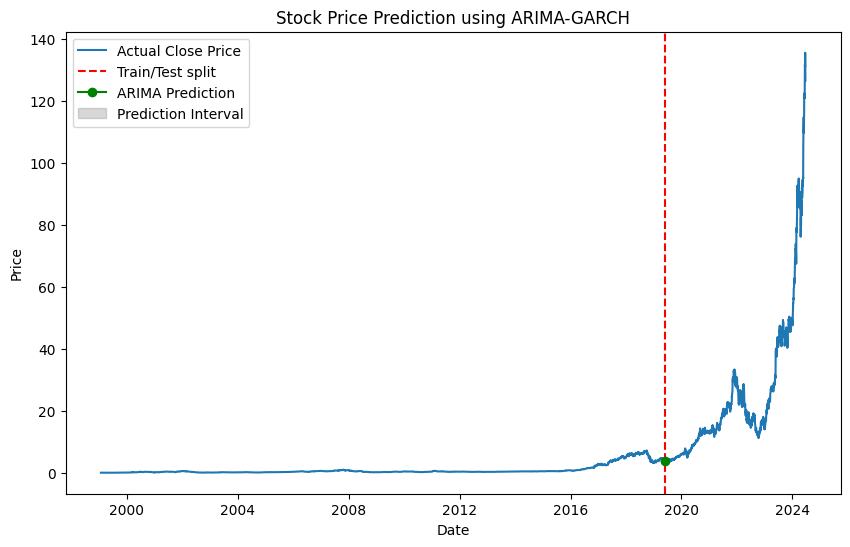

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Actual Close Price')
plt.axvline(df.index[train_size], color='r', linestyle='--', label='Train/Test split')
plt.plot(pd.Series(arima_pred.iloc[0], index=[df.index[train_size]]), color='g', marker='o', label='ARIMA Prediction')
plt.fill_between([df.index[train_size]], arima_garch_lower.iloc[0], arima_garch_upper.iloc[0], color='gray', alpha=0.3, label='Prediction Interval')
plt.legend()
plt.title('Stock Price Prediction using ARIMA-GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()